In [1]:
SEED = 2023

# Import libraries
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.feature_selection import RFECV

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

In [3]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [4]:
# Preview test dataset
test.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
0,ID_L7RNFK5JC9,32.709430,121124.141400,30.407359,0.496719,3.999064,0.000000,335.565884,737.338490,1.844013,1.910664,0.311038,0.0,726.318848,20.008686
1,ID_KUTY5K1G5F,2.065990,2029.713475,29.000000,0.000000,3.665467,0.000000,63.845771,41.119875,0.733093,0.577589,0.044430,0.0,385.473839,33.015399
2,ID_H6PJWKU831,114.524684,3888.550764,28.000000,0.486075,0.777719,0.199985,11.354698,11.332477,0.177764,0.133323,0.000000,0.0,504.828540,30.091141
3,ID_DNQXNVTXHE,27.036810,5581.324782,25.000000,0.314968,1.789015,0.000000,44.297028,13.430214,0.302369,0.125987,0.000000,0.0,465.950312,22.211252
4,ID_8CRTF1BJOD,1.177267,176.634467,28.000000,0.000000,1.710369,0.000000,88.161746,57.508380,0.888503,0.777440,0.000000,0.0,771.665166,31.032570


In [5]:
# Preview sample submission file
samplesubmission.head()

,ID,Target
0,ID_L7RNFK5JC9,0
1,ID_KUTY5K1G5F,0
2,ID_H6PJWKU831,0
3,ID_DNQXNVTXHE,0
4,ID_8CRTF1BJOD,0


In [6]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((8908, 16), (3818, 15), (3818, 2))

Feature Imbedding

In [7]:
# Train statistical summary
train.describe(include = 'all')

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
count,8908,8908.000000,8.908000e+03,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8.908000e+03,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000,8908.000000
unique,8908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_4W8AP96UO6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36.429205,1.135564e+05,29.811900,0.496405,5.353260,1.046153,559.546628,1.655804e+04,4.795485,12.625792,0.988036,0.004177,2779.178084,28.436192,0.269870
std,NaN,75.884647,4.896846e+05,5.691411,1.593626,19.286690,15.667814,1939.745234,9.042803e+04,20.797585,61.246541,12.495768,0.082923,4996.003166,3.970140,0.443917
min,NaN,0.000000,0.000000e+00,1.000000,0.000000,0.044459,0.000000,1.197890,1.554938e+00,0.022183,0.022183,0.000000,0.000000,16.143987,18.057942,0.000000
25%,NaN,1.394404,8.136318e+02,27.000000,0.000000,0.755629,0.000000,33.843800,2.737770e+01,0.399999,0.333225,0.000000,0.000000,351.620535,25.266134,0.000000
50%,NaN,11.613803,4.930482e+03,28.000000,0.034734,1.711077,0.000000,67.366295,8.905770e+01,0.710898,0.635705,0.022222,0.000000,682.943866,28.543826,0.000000
75%,NaN,34.494953,3.940357e+04,30.000000,0.451350,5.845619,0.022229,221.314810,5.613814e+02,1.555063,1.711155,0.088887,0.000000,1356.673217,30.969542,1.000000


In [8]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [9]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()


(False, False)

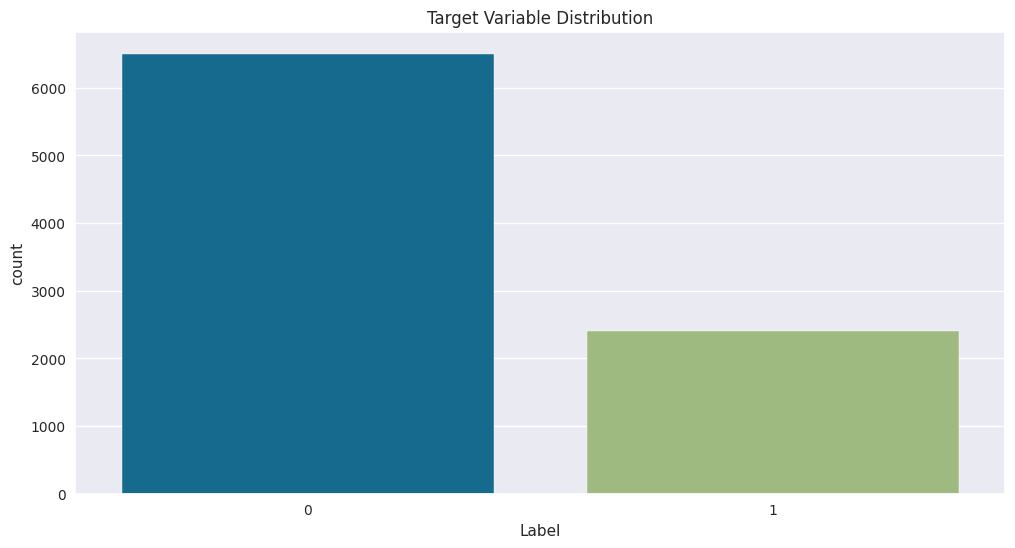

In [10]:
# A box plot showing outliers
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Label', data = train)
plt.title('Target Variable Distribution')
plt.show()

<ipython-input-11-4f4d85818d51>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


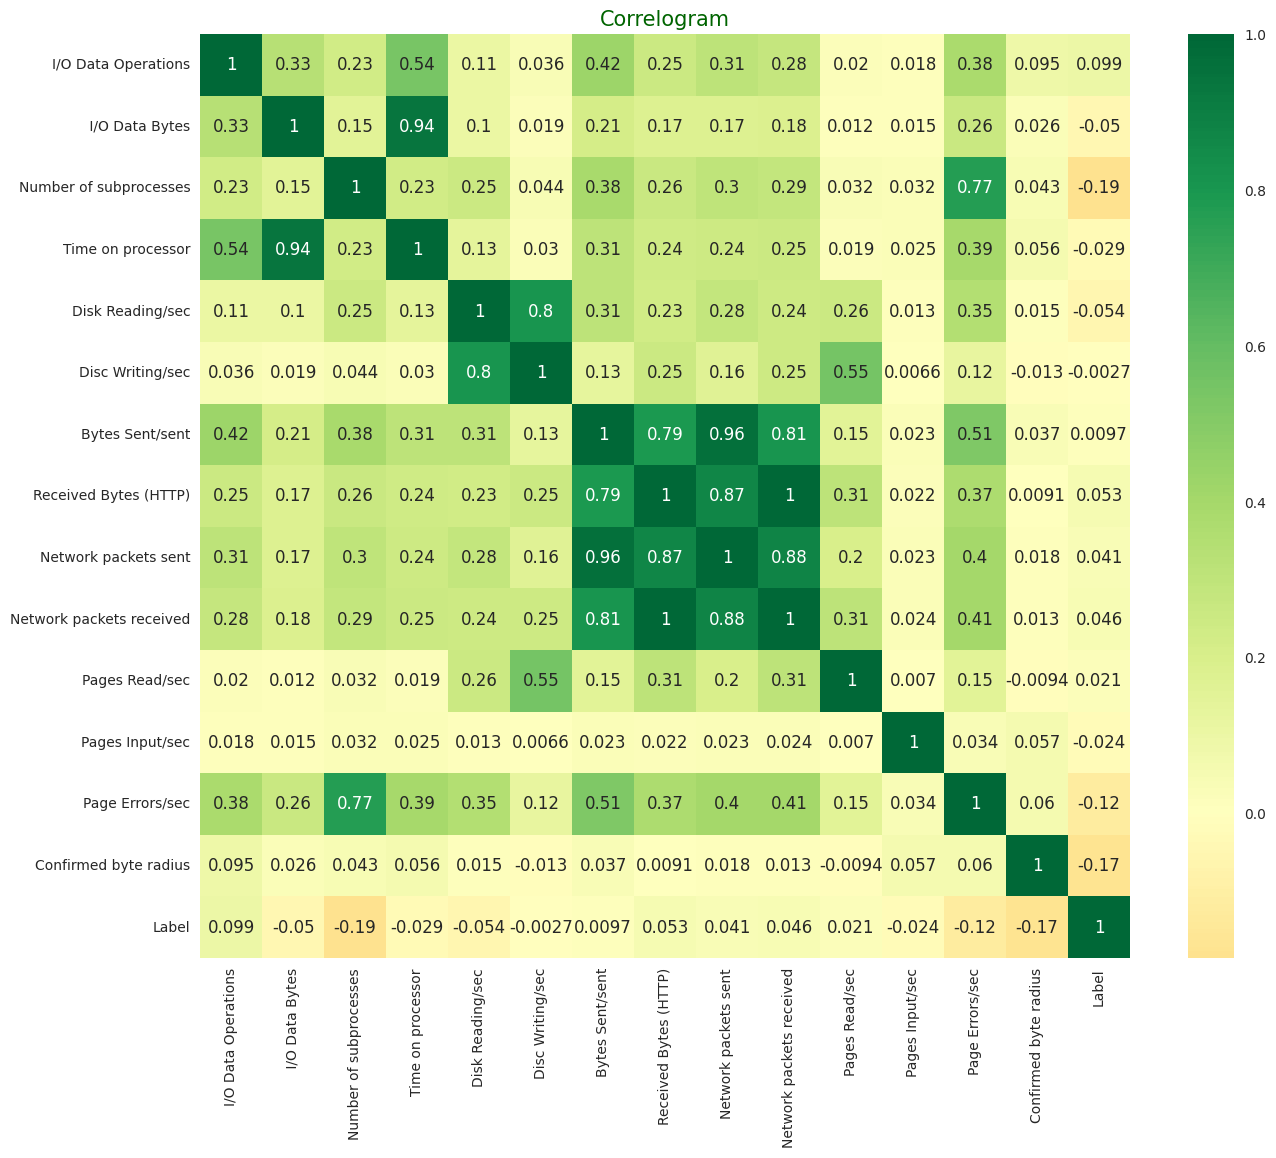

In [11]:
# Plotting a heatmap to show correlations between variables
corr = train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [12]:
#scale numerical features for logistic model
features = train.drop(columns=['ID','Label']).columns
target = 'Label'

# define standard scaler
scaler = StandardScaler()

# transform data
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [13]:
#split train data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train[features],
                                                    train[target].to_frame(),
                                                    stratify=train[target], #to account for class imbalance
                                                    test_size=0.2,
                                                    random_state=SEED
                                                    )

In [14]:
# split method for feature selection

kfold= StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)

In [15]:
def select_features(X_train, y_train, X_test, algorithm: object, step: int, min_feature: int) -> pd.DataFrame:
    """Function to select all relevant features in the dataset

    Parameters:
        datasets: the training and test dataset needed to train the model
        algorithm: algorithm used to select features
        step: number of steps to take during elimination process
        min_feature: minimum number of features to select

    Return:
        dataset: new dataset with the selected features
    """

    # instantiate the algorithm
    algo = RFECV(estimator=algorithm,
                 step=step,
                 cv=kfold,
                 min_features_to_select=min_feature,
                 scoring='f1',
                 verbose=2,
                 n_jobs=-1)

    # fit the algorithm to the data
    algo.fit(X_train, y_train)

    # transform train input data
    X_train_ts = algo.transform(X_train)

    # transform test input data
    X_test_ts = algo.transform(X_test)

    return X_train_ts, X_test_ts, algo

In [16]:
def select_features(X_train, y_train, X_test, algorithm: object, step: int, min_feature: int) -> pd.DataFrame:
    """Function to select all relevant features in the dataset

    Parameters:
        datasets: the training and test dataset needed to train the model
        algorithm: algorithm used to select features
        step: number of steps to take during elimination process
        min_feature: minimum number of features to select

    Return:
        dataset: new dataset with the selected features
    """

    # instantiate the algorithm
    algo = RFECV(estimator=algorithm,
                 step=step,
                 cv=kfold,
                 min_features_to_select=min_feature,
                 scoring='f1',
                 verbose=2,
                 n_jobs=-1)

    # fit the algorithm to the data
    algo.fit(X_train, y_train)

    # transform train input data
    X_train_ts = algo.transform(X_train)

    # transform test input data
    X_test_ts = algo.transform(X_test)

    return X_train_ts, X_test_ts, algo

In [17]:
# applying feature selection method

algo = XGBClassifier()
min_feature = 1
step = 1

X_train_fs, X_test_fs, algo = select_features(X_train, y_train, X_test, algo, step, min_feature)

print('Relevant number of features:', algo.n_features_)
print('\nHere are the features:')
print('----------------------------------')

pd.DataFrame(X_train.columns[algo.ranking_ == 1], columns=['Selected Features'])

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Relevant number of features: 11

Here are the features:
----------------------------------


,Selected Features
0,I/O Data Operations
1,I/O Data Bytes
2,Number of subprocesses
3,Time on processor
4,Disk Reading/sec
5,Disc Writing/sec
6,Bytes Sent/sent
7,Received Bytes (HTTP)
8,Network packets received
9,Page Errors/sec


In [18]:
# creating new train and test data using selected features

X_train_fs = pd.DataFrame(X_train_fs, columns=list(X_train.columns[algo.ranking_ == 1]))
X_test_fs = pd.DataFrame(X_test_fs, columns=list(X_test.columns[algo.ranking_ == 1]))

In [19]:
#X_train_fs_z_scaler

model = XGBClassifier()
model.fit(X_train_fs, y_train)

#print('Accuracy  classifier on training set: {:.3f}'.format(estimator_xgb.score(X_train_fs_z_scaler, y_train)))
print('Accuracy  classifier on test set: {:.4f}'.format(model.score(X_test_fs, y_test)))

y_pred = model.predict(X_test_fs)

f1 = f1_score(y_test, y_pred)
print('f1 score: {:.4f}'.format(f1))

Accuracy  classifier on test set: 0.9809
f1 score: 0.9641


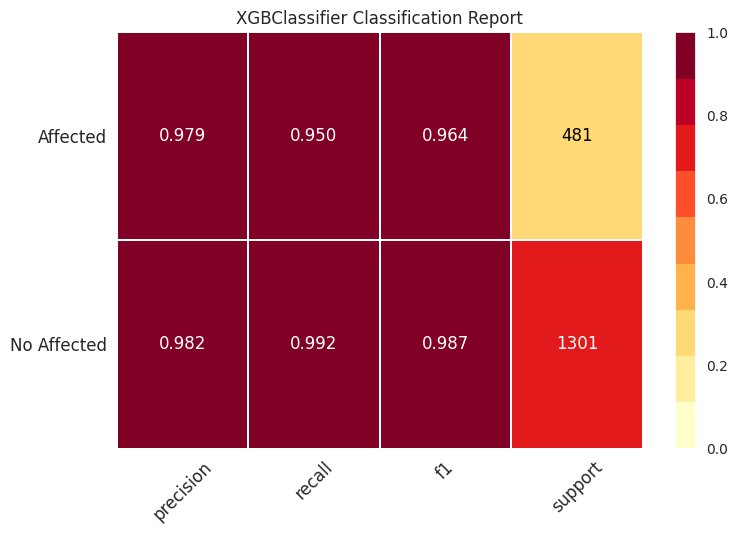

In [20]:
# Specify the target classes
classes = ['No Affected', 'Affected']

# instantiate the report visualizer
visualizer = ClassificationReport(model, classes=classes, support=True)

# fit and visualize it
visualizer.fit(X_train_fs, y_train)
visualizer.score(X_test_fs, y_test)
visualizer.show()
plt.show()

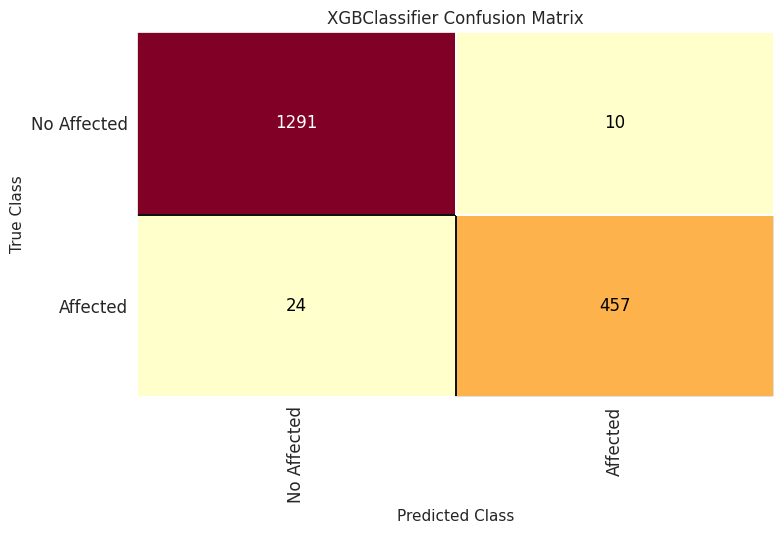

In [21]:
# instantiate the matrix
crypto_cm = ConfusionMatrix(model, classes=classes,label_encoder={0: 'Not Affected', 1: 'Affected'})

# fit and plot the results
crypto_cm.fit(X_train_fs, y_train)
crypto_cm.score(X_test_fs, y_test)
crypto_cm.show()
plt.show()

In [22]:
# get selected columns

pred_columns = X_train_fs.columns

In [23]:
# make predictions on test set

test['Target'] = model.predict(test[pred_columns])

In [24]:
# get id and target column

sub = test[['ID', 'Target']]

In [25]:
sub.head()

,ID,Target
0,ID_L7RNFK5JC9,0
1,ID_KUTY5K1G5F,0
2,ID_H6PJWKU831,1
3,ID_DNQXNVTXHE,1
4,ID_8CRTF1BJOD,0


In [27]:
# create submission file

sub.to_csv('team8_submission4.csv', index=False)